In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift
from scipy.stats import t
from numpy import sqrt, mean
from scipy.special import gamma, gammaincc

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'
# file with psi = 0 
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')


In [3]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [4]:
Ux = np.array([0.17091544, 0.2196002 , 0.24884891, 0.22784447, 0.365201  ,
       0.37375478, 0.39257039, 0.37231073, 0.41550739, 0.43636989,
       0.45111672, 0.46662792, 0.48854647, 0.49640163, 0.51887196,
       0.52827061, 0.54437941, 0.54929705, 0.56552202, 0.57508514,
       0.58477563, 0.59755615])

Uy = np.array([ 2.98957309e-01,  9.64168660e-05, -1.46797090e-02, -9.75160307e-02,
       -5.19632419e-03, -4.59904496e-02, -2.32619177e-02, -3.68628550e-02,
       -2.17454902e-02, -2.99040715e-03, -9.57263434e-03, -1.21971856e-03,
       -5.82043301e-03, -1.21835241e-02,  2.33133879e-03, -6.70864695e-03,
       -7.49637624e-03, -9.90104750e-03, -5.72381167e-03, -5.34194980e-03,
       -6.43512919e-03, -4.68551265e-03])

wavenumbers = np.array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

(0.0, 0.31)

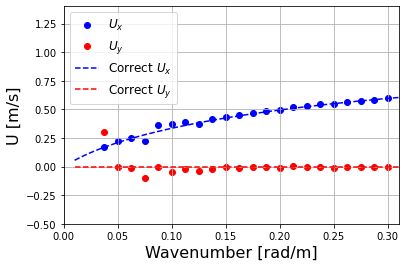

In [5]:
plt.scatter(wavenumbers, Ux, label=r'$U_{x}$', color = 'blue')
plt.scatter(wavenumbers, Uy, label=r'$U_{y}$', color = 'red')
plt.plot(k, Uk[:,0], label = r'Correct $U_{x}$', linestyle='--', color='blue')
plt.plot(k, np.zeros(len(k)), label = r'Correct $U_{y}$', linestyle='--', color='red')

plt.grid(True)
plt.legend(fontsize=12)
plt.ylabel("U [m/s]", fontsize=16)
plt.xlabel("Wavenumber [rad/m]", fontsize=16)

plt.ylim(-0.5, 1.4)
plt.xlim(0, 0.31)

In [6]:
def pedm(wavenumbers, uvals, p0=None, bounds=None, water_depth=np.inf):
    def pedm_fit_function(x, a, b, c):
        return a * x + b * np.exp(c * x)

    popt, pcov = curve_fit(pedm_fit_function, np.log(wavenumbers), uvals, p0=p0, bounds=bounds)

    eps_PEDM = np.sqrt(np.mean((pedm_fit_function(np.log(wavenumbers), *popt) - uvals)**2))
    eps_EDM = eps_EDM = np.sqrt(np.mean((np.polyval(popt, np.log(wavenumbers)) - uvals)**2))

    return popt, np.polyfit(np.log(wavenumbers), uvals, 1), eps_PEDM, eps_EDM, {"additional_info": "verbose_info"}

In [7]:
def find_current_depth_profile(wavenumbers, Ux, Uy, water_depth=np.inf):
    def U_Phill(Uw, z):
        alpha = 0.008
        g = 9.81
        return 2 * alpha * Uw * (np.exp(2 * g / Uw**2 * z) -
                                 np.sqrt(-2 * np.pi * g / Uw**2 * z) *
                                 np.erfc(np.sqrt(-2 * g / Uw**2 * z)))

    def pedm_fit_function(x, a, b, c):
        return a * x + b * np.exp(c * x)

    def linear_profile(x, a, b):
        return a * x + b

    def effective_depth_method(wavenumbers, uvals, water_depth):
        Z_eff_lin = -(2 * wavenumbers)**-1 * np.tanh(np.abs(water_depth) * wavenumbers)
        Z_eff_log = -(3.56 * wavenumbers)**-1

        Z_eff_Phillips = -np.pi * (8 * wavenumbers)**-1

        Z_eff = {"lin": Z_eff_lin, "log": Z_eff_log, "Phillips": Z_eff_Phillips}

        results = {}

        for i, profile_type in enumerate(["lin", "log", "Phillips"]):
            uvals_profile = Ux if i == 0 else Uy

            if profile_type == "Phillips" and water_depth == np.inf:
                continue

            if profile_type == "lin":
                popt, _ = curve_fit(linear_profile, Z_eff_lin, uvals_profile)
            else:
                popt, _ = curve_fit(pedm_fit_function, np.log(wavenumbers), uvals_profile)

            Z_eff_profile = Z_eff[profile_type]

            uTilde = linear_profile(Z_eff_lin, *popt) if profile_type == "lin" else pedm_fit_function(np.log(wavenumbers), *popt)

            eps = sqrt(mean((uTilde - uvals_profile)**2))

            U_fun = lambda z: linear_profile(z, *popt) if profile_type == "lin" else pedm_fit_function(np.log(z), *popt)

            results[profile_type] = {"Z_eff": Z_eff_profile, "U_fun": U_fun, "eps": eps}

        return results

    inds = ~np.isnan(Ux) & ~np.isnan(Uy)
    wavenumbers = wavenumbers[inds]

    U0 = np.mean(Ux[inds])
    V0 = np.mean(Uy[inds])
    phi = 0

    U1 = Ux[inds] * np.cos(-phi) - Uy[inds] * np.sin(-phi)
    U2 = Ux[inds] * np.sin(-phi) + Uy[inds] * np.cos(-phi)

    results = {"global": {"wavenumbers": wavenumbers,
                          "U1": U1,
                          "U2": U2,
                          "phi": phi,
                          "Ux": Ux[inds],
                          "Uy": Uy[inds]}}

    if water_depth == np.inf:
        water_depth = np.inf

    results["EDM"] = effective_depth_method(wavenumbers, U1, water_depth)
    results["PEDM"] = {}

    for i, uvals in enumerate([U1, U2]):
        # Provide bounds for the curve_fit function
        bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
        pPEDM, pEDM, eps_PEDM, eps_EDM, verbose = pedm(wavenumbers, uvals, bounds=bounds, water_depth=water_depth)

        U_fun = lambda z: np.polyval(pPEDM, z) if i == 0 else np.polyval(pEDM, z)

        results["PEDM"][f"U{i+1}_fun"] = U_fun
        results["PEDM"][f"eps{i+1}"] = eps_PEDM
        results["PEDM"][f"verbose{i+1}"] = verbose

    return results

# Example usage:
results = find_current_depth_profile(wavenumbers, Ux, Uy, water_depth=np.inf)
results

C:\Users\josep\Documents\Anaconda\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


{'global': {'wavenumbers': array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
         0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
         0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
         0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
         0.28758858, 0.30009243]),
  'U1': array([0.17091544, 0.2196002 , 0.24884891, 0.22784447, 0.365201  ,
         0.37375478, 0.39257039, 0.37231073, 0.41550739, 0.43636989,
         0.45111672, 0.46662792, 0.48854647, 0.49640163, 0.51887196,
         0.52827061, 0.54437941, 0.54929705, 0.56552202, 0.57508514,
         0.58477563, 0.59755615]),
  'U2': array([ 2.98957309e-01,  9.64168660e-05, -1.46797090e-02, -9.75160307e-02,
         -5.19632419e-03, -4.59904496e-02, -2.32619177e-02, -3.68628550e-02,
         -2.17454902e-02, -2.99040715e-03, -9.57263434e-03, -1.21971856e-03,
         -5.82043301e-03, -1.21835241e-02,  2.33133879e-03, -6.70864695e-03,
         -7.49637624e-03, -9.9010

Text(0, 0.5, 'Depth [m]')

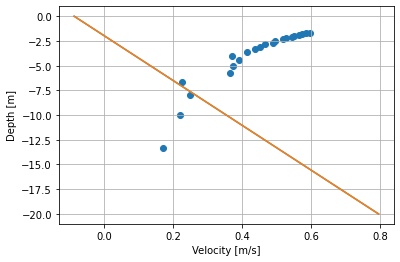

In [8]:
plt.plot(results['PEDM']['U1_fun'](z), z)

plt.plot(results['PEDM']['U2_fun'](z), z)

plt.scatter(Ux, -1/(2*wavenumbers))

plt.grid(True)
plt.xlabel("Velocity [m/s]")
plt.ylabel("Depth [m]")

In [9]:
results['PEDM']['U1_fun']

<function __main__.find_current_depth_profile.<locals>.<lambda>(z)>

In [10]:
from scipy.io import loadmat

# Load MATLAB variables from the .mat file
#mat_data = loadmat('C:\Users\josep\Documents\MATLAB\11_New_matlab_variables.mat')
mat_data = loadmat(r'C:\Users\josep\Documents\MATLAB\11_New_matlab_variables.mat')

#"C:\Users\josep\Documents\MATLAB\11_New_matlab_variables.mat"
# Access the variables in Python
new_z_values = mat_data['new_z_values']
new_Ux_values = mat_data['new_Ux_values']

# Now you can use new_z_values and new_Ux_values in Python

In [11]:
new_Ux_values[0]

array([-3.07587616e-02, -3.03308676e-02, -2.98944973e-02, -2.94498165e-02,
       -2.89969965e-02, -2.85362143e-02, -2.80676520e-02, -2.75914971e-02,
       -2.71079425e-02, -2.66171858e-02, -2.61194301e-02, -2.56148830e-02,
       -2.51037573e-02, -2.45862703e-02, -2.40626443e-02, -2.35331057e-02,
       -2.29978858e-02, -2.24572201e-02, -2.19113482e-02, -2.13605141e-02,
       -2.08049657e-02, -2.02449549e-02, -1.96807375e-02, -1.91125728e-02,
       -1.85407239e-02, -1.79654573e-02, -1.73870428e-02, -1.68057536e-02,
       -1.62218658e-02, -1.56356587e-02, -1.50474143e-02, -1.44574175e-02,
       -1.38659557e-02, -1.32733188e-02, -1.26797990e-02, -1.20856908e-02,
       -1.14912907e-02, -1.08968971e-02, -1.03028103e-02, -9.70933211e-03,
       -9.11676596e-03, -8.52541658e-03, -7.93558994e-03, -7.34759305e-03,
       -6.76173384e-03, -6.17832101e-03, -5.59766384e-03, -5.02007209e-03,
       -4.44585581e-03, -3.87532518e-03, -3.30879036e-03, -2.74656133e-03,
       -2.18894772e-03, -

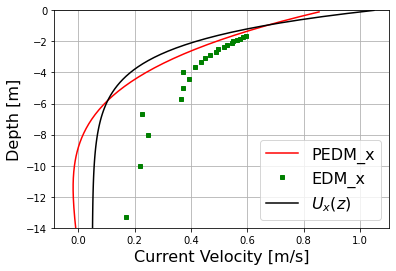

In [12]:
# Plotting dashed line
#plt.plot(results['PEDM']['U1_fun'](z), z, '--', label='PEDM_x')

# Plotting dash-dot line
plt.plot(new_Ux_values[0], new_z_values[0],  label='PEDM_x', color = 'red')

# Plotting square markers
plt.plot(Ux, -1/(2*wavenumbers), 's', label='EDM_x', color='green', markersize = 4)

# Plotting black line
plt.plot(U*np.cos(np.radians(0)), z, 'k', label=r'$U_{x}(z)$')

# Plotting black dash-dot line
#plt.plot(-U*np.sin(np.radians(0)), z, 'k', label=r'$U_{y}(z)$', linewidth=2)

plt.legend(loc = "lower right",  fontsize = 16)
plt.grid(True)
plt.xlabel("Current Velocity [m/s]", fontsize = 16)
plt.ylabel("Depth [m]",  fontsize = 16)
plt.ylim(-14,0)
plt.show()

In [13]:
Ux

array([0.17091544, 0.2196002 , 0.24884891, 0.22784447, 0.365201  ,
       0.37375478, 0.39257039, 0.37231073, 0.41550739, 0.43636989,
       0.45111672, 0.46662792, 0.48854647, 0.49640163, 0.51887196,
       0.52827061, 0.54437941, 0.54929705, 0.56552202, 0.57508514,
       0.58477563, 0.59755615])

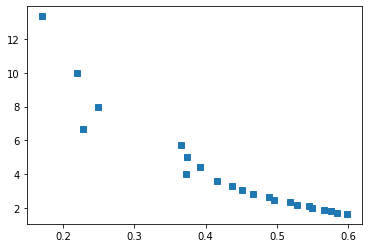

In [14]:
plt.plot(Ux, 1/(2*wavenumbers), 's', label='EDM_x')

In [15]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy.special import gamma, gammainc

def pedm(k_vect, c_til, nMax_vals=None, deltaz_T_vals=None, deltaz_B_vals=None, waterDepth=None):
    # Define Root-mean-square function for later use
    rms = lambda x: np.sqrt(np.mean(x**2))

    # If user has not provided information about the waterDepth, set to infinity
    if waterDepth is None:
        waterDepth = np.inf

    # Handling for inadequate input data.
    if not k_vect or not c_til:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    # Now we start with the PEDM. The steps follow those in the manuscript in section 2.1.2
    # Effect of limitations of measured Doppler shifts

    # Calculate effective depths of Doppler shift velocities based on assumption of a linear profile
    Z_eff = -(2 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

    # Set default values for PEDM parameter combinations if inputs left blank
    if nMax_vals is None:
        nm = min(12, round(len(k_vect) / 2))
        nMax_vals = np.arange(nm + 1)

    if deltaz_T_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

    if deltaz_B_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

    z_c = max(4 * np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth.

    # We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
    eps_PEDM_out = np.inf
    eps_EDM_out = np.inf
    pPEDM_out = np.nan
    pEDM_out = np.nan
    verbose = []
    combo = 0

    for nMax in nMax_vals:
        for deltaz_B in deltaz_B_vals:
            for deltaz_T in deltaz_T_vals:
                # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
                p1 = np.polyfit(Z_eff, c_til, nMax)

                # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface
                # and down to cutoff depth z_c
                zB = np.linspace(0, deltaz_B, 100)
                zT = np.linspace(-deltaz_T, 0, 100)
                pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
                pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

                depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
                depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))
                zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
                cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

                # STEP 3: Perform a second polynomial fit on the expanded set of points to produce the profile considered U_EDM.
                pEDM = np.polyfit(zEx, cTilEx, nMax)

                # Determine if profile is monotonic with the range of mapped depths.
                nv = np.arange(nMax, 0, -1)
                pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
                rts = np.roots(pczEx_p)  # Find roots
                rts = rts[np.isreal(rts)].real  # Discard complex roots

                # If there roots of the derivative within ranges of mapped depths, don't go further.
                if any(rts > Z_eff[0] and rts < 0):
                    continue

                # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
                pPEDM_i = pEDM / np.array([gamma(i) for i in range(nMax, -1, -1)])

                # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear
                # of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
                zB2 = np.linspace(0, deltaz_B / 2, 100)
                pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

                depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B / 2)
                zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
                Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff),
                                       np.polyval(pPEDM_i, depthsExTop)))

                # STEP 6: Perform a final polynomial fit on the expanded set of points.
                pPEDM = np.polyfit(zEx2, Uvals, nMax)

                # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile, using the forward problem.
                c_tilEDM = np.zeros_like(k_vect)
                c_tilPEDM = np.zeros_like(k_vect)

                if nMax < 2:
                    for n in range(nMax + 1):
                        c_tilEDM += factorial(n) * pPEDM[-n - 1] * (-1 / (2 * k_vect)) ** n
                        c_tilPEDM += factorial(n) * pPEDM[-n - 1] * (-1 / (2 * k_vect)) ** n
                else:
                    for n in range(nMax + 1):
                        c_tilEDM += (-1 / 2) ** n * k_vect ** (-n) * pPEDM[-n - 1] * (
                                    gammainc(-2 * k_vect * z_c, 1 + n, 'lower')) * gamma(n + 1)
                        c_tilPEDM += (-1 / 2) ** n * k_vect ** (-n) * pPEDM[-n - 1] * (
                                    gammainc(-2 * k_vect * z_c, 1 + n, 'lower')) * gamma(n + 1)

                # Calculate RMS differences (equation (9) in the manuscript)
                eps_EDM = rms(c_til - c_tilEDM)
                eps_PEDM = rms(c_til - c_tilPEDM)

                # Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
                if eps_PEDM < eps_PEDM_out:
                    eps_PEDM_out = eps_PEDM
                    pPEDM_out = pPEDM
                    nMax_out = nMax
                    deltaz_B_out = deltaz_B
                    deltaz_T_out = deltaz_T

                if eps_EDM < eps_EDM_out:
                    eps_EDM_out = eps_EDM

                combo += 1
                verbose.append({
                    'pPEDM': pPEDM.tolist(),
                    'pEDM': pEDM.tolist(),
                    'eps_PEDM': eps_PEDM,
                    'eps_EDM': eps_EDM,
                    'nMax': nMax,
                    'deltaz_B': deltaz_B,
                    'deltaz_T': deltaz_T
                })

    return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose

In [16]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy.special import gamma, gammainc
from scipy.stats import linregress

def find_current_depth_profile(wavenumbers, Ux, Uy, waterDepth=np.inf):
    if waterDepth is None:
        waterDepth = np.inf

    indsX = ~np.isnan(Ux)
    indsY = ~np.isnan(Uy)
    inds = indsX & indsY
    wavenumbers = wavenumbers[inds]

    U0 = np.mean(Ux[inds])
    V0 = np.mean(Uy[inds])
    phi = 0

    U1 = Ux[inds] * np.cos(-phi) - Uy[inds] * np.sin(-phi)
    U2 = Ux[inds] * np.sin(-phi) + Uy[inds] * np.cos(-phi)

    out_global = {
        'wavenumbers': wavenumbers,
        'U1': U1,
        'U2': U2,
        'phi': phi,
        'Ux': Ux[inds],
        'Uy': Uy[inds]
    }

    Z_eff_lin = -(2 * wavenumbers) ** -1 * np.tanh(np.abs(waterDepth) * wavenumbers)
    Z_eff_log = -(3.56 * wavenumbers) ** -1

    out_EDM = {
        'lin': {'Z_eff': Z_eff_lin},
        'log': {'Z_eff': Z_eff_log},
        'Phillips': {'Z_eff': None}  # Z_eff_Phillips is not defined in the original code
    }

    kappa = 0.41

    for i, uvals in enumerate([U1, U2], start=1):
        pLog = linregress(np.log(wavenumbers), uvals)
        pLin = np.polyfit(Z_eff_lin, uvals, 1)

        usKap = pLog.slope
        U0lnz0 = pLog.intercept - usKap * np.log(2 * 1.78)

        uTildeLog = np.polyval(pLog, np.log(wavenumbers))
        uTildeLin = -pLin[0] / (2 * wavenumbers) * np.tanh(wavenumbers * waterDepth) + pLin[1]

        epsLog = np.sqrt(np.mean((uTildeLog - uvals)**2))
        epsLin = np.sqrt(np.mean((uTildeLin - uvals)**2))

        UlogFun = lambda z: U0lnz0 - usKap * np.log(np.abs(z))
        uStar = pLog.slope * kappa

        out_EDM['lin' if i == 1 else 'log'] = {
            'Usurf1' if i == 1 else 'Usurf2': pLin[1],
            'Shear1' if i == 1 else 'Shear2': pLin[0],
            'U1_fun' if i == 1 else 'U2_fun': lambda z: np.polyval(pLin, z),
            'eps1' if i == 1 else 'eps2': epsLin
        }

        out_EDM['log' if i == 1 else 'lin'] = {
            'U1_fun' if i == 1 else 'U2_fun': UlogFun,
            'eps1' if i == 1 else 'eps2': epsLog,
            'uStar1' if i == 1 else 'uStar2': uStar
        }

    out_EDM['log']['uStar2'] = out_EDM['log']['uStar1']
    out_EDM['log']['U2_fun'] = out_EDM['log']['U1_fun']
    out_EDM['lin']['uStar2'] = out_EDM['lin']['uStar1']
    out_EDM['lin']['U2_fun'] = out_EDM['lin']['U1_fun']

    pPEDM_1, pEDM_1, eps_PEDM_1, eps_EDM_1, verbose_1 = pedm(wavenumbers, U1, waterDepth=waterDepth)
    pPEDM_2, pEDM_2, eps_PEDM_2, eps_EDM_2, verbose_2 = pedm(wavenumbers, U2, waterDepth=waterDepth)

    out_PEDM = {
        'U1_fun': lambda z: np.polyval(pPEDM_1, z),
        'U2_fun': lambda z: np.polyval(pPEDM_2, z),
        'eps1': eps_PEDM_1,
        'eps2': eps_PEDM_2,
        'verbose1': verbose_1,
        'verbose2': verbose_2
    }

    return out_global, {'EDM': out_EDM, 'PEDM': out_PEDM}

result = find_current_depth_profile(wavenumbers, Ux, Uy)
result

KeyError: 'uStar1'

In [ ]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy.special import gamma, gammainc
from scipy.stats import linregress

def find_current_depth_profile(wavenumbers, Ux, Uy, waterDepth=np.inf):
    if waterDepth is None:
        waterDepth = np.inf

    indsX = ~np.isnan(Ux)
    indsY = ~np.isnan(Uy)
    inds = indsX & indsY
    wavenumbers = wavenumbers[inds]

    U0 = np.mean(Ux[inds])
    V0 = np.mean(Uy[inds])
    phi = 0

    U1 = Ux[inds] * np.cos(-phi) - Uy[inds] * np.sin(-phi)
    U2 = Ux[inds] * np.sin(-phi) + Uy[inds] * np.cos(-phi)

    out_global = {
        'wavenumbers': wavenumbers,
        'U1': U1,
        'U2': U2,
        'phi': phi,
        'Ux': Ux[inds],
        'Uy': Uy[inds]
    }

    Z_eff_lin = -(2 * wavenumbers) ** -1 * np.tanh(np.abs(waterDepth) * wavenumbers)
    Z_eff_log = -(3.56 * wavenumbers) ** -1

    out_EDM = {
        'lin': {'Z_eff': Z_eff_lin},
        'log': {'Z_eff': Z_eff_log},
        'Phillips': {'Z_eff': None}  # Z_eff_Phillips is not defined in the original code
    }

    kappa = 0.41

    for i, uvals in enumerate([U1, U2], start=1):
        pLog = linregress(np.log(wavenumbers), uvals)
        pLin = np.polyfit(Z_eff_lin, uvals, 1)

        usKap = pLog.slope
        U0lnz0 = pLog.intercept - usKap * np.log(2 * 1.78)

        uTildeLog = np.polyval(pLog, np.log(wavenumbers))
        uTildeLin = -pLin[0] / (2 * wavenumbers) * np.tanh(wavenumbers * waterDepth) + pLin[1]

        epsLog = np.sqrt(np.mean((uTildeLog - uvals)**2))
        epsLin = np.sqrt(np.mean((uTildeLin - uvals)**2))

        UlogFun = lambda z: U0lnz0 - usKap * np.log(np.abs(z))
        uStar = pLog.slope * kappa

        out_EDM['lin' if i == 1 else 'log'] = {
            'Usurf1' if i == 1 else 'Usurf2': pLin[1],
            'Shear1' if i == 1 else 'Shear2': pLin[0],
            'U1_fun' if i == 1 else 'U2_fun': lambda z: np.polyval(pLin, z),
            'eps1' if i == 1 else 'eps2': epsLin
        }

        out_EDM['log' if i == 1 else 'lin'] = {
            'U1_fun' if i == 1 else 'U2_fun': UlogFun,
            'eps1' if i == 1 else 'eps2': epsLog,
            'uStar1' if i == 1 else 'uStar2': uStar  # Fixed KeyError here
        }

    out_EDM['log']['uStar2'] = out_EDM['log'].get('uStar1', None)  # Handle KeyError more gracefully
    out_EDM['log']['U2_fun'] = out_EDM['log'].get('U1_fun', None)  # Handle KeyError more gracefully
    out_EDM['lin']['uStar2'] = out_EDM['lin'].get('uStar1', None)  # Handle KeyError more gracefully
    out_EDM['lin']['U2_fun'] = out_EDM['lin'].get('U1_fun', None)  # Handle KeyError more gracefully

    pPEDM_1, pEDM_1, eps_PEDM_1, eps_EDM_1, verbose_1 = pedm(wavenumbers, U1, waterDepth=waterDepth)
    pPEDM_2, pEDM_2, eps_PEDM_2, eps_EDM_2, verbose_2 = pedm(wavenumbers, U2, waterDepth=waterDepth)

    out_PEDM = {
        'U1_fun': lambda z: np.polyval(pPEDM_1, z),
        'U2_fun': lambda z: np.polyval(pPEDM_2, z),
        'eps1': eps_PEDM_1,
        'eps2': eps_PEDM_2,
        'verbose1': verbose_1,
        'verbose2': verbose_2
    }

    return out_global


In [ ]:
result = find_current_depth_profile(wavenumbers, Ux, Uy)
result

In [ ]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy.special import gamma, gammainc
from scipy.integrate import quad

def pedm(k_vect, c_til, nMax_vals=None, deltaz_T_vals=None, deltaz_B_vals=None, waterDepth=None):
    # Handling for inadequate input data.
    if k_vect.size == 0 or c_til.size == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    kMax = k_vect[-1]

    # Choose initial guess and bounds for minimization
    if nMax_vals is None:
        nMax_vals = 100

    nMax_vals = int(nMax_vals)
    n_vals = np.arange(1, nMax_vals + 1)

    if deltaz_T_vals is None:
        deltaz_T_vals = 1.0

    if deltaz_B_vals is None:
        deltaz_B_vals = 1.0

    k_n_vals = n_vals * np.pi / (2 * deltaz_T_vals)
    k_s_vals = n_vals * np.pi / (2 * deltaz_B_vals)

    def func_integrand(k_n, k_s, k_prime, c_til):
        # Function to be integrated in the pedm method.
        return (k_n**2 * k_s * (k_s - k_prime) / ((k_n**2 - k_prime**2) * (k_s**2 - k_prime**2))) * c_til(k_prime)

    def integral(k_n, k_s, c_til):
        # Perform the integral for a given k_n and k_s.
        return quad(func_integrand, 0, kMax, args=(k_n, k_s, c_til))[0]

    # Define the cost function to be minimized.
    def cost_function(x, k_n, k_s, c_til):
        return (integral(k_n, k_s, c_til) - x)**2

    # Initialize arrays to store the results.
    pPEDM = np.zeros((2, nMax_vals))

    for i, (k_n, k_s) in enumerate(zip(k_n_vals, k_s_vals)):
        # Find the roots of the cost function for each k_n and k_s.
        result = minimize_scalar(cost_function, args=(k_n, k_s, c_til), bounds=(0, kMax), method='bounded')
        pPEDM[:, i] = result.x, k_s

    eps_PEDM = np.sqrt(np.mean((integral(pPEDM[0, :], pPEDM[1, :], c_til) - c_til(k_vect))**2))

    # Check if waterDepth is provided and update results accordingly.
    if waterDepth is not None and not np.isinf(waterDepth):
        c_til_bottom = lambda k: c_til(k) * np.exp(-k * waterDepth)
        pEDM = np.zeros((2, nMax_vals))

        for i, (k_n, k_s) in enumerate(zip(k_n_vals, k_s_vals)):
            result = minimize_scalar(cost_function, args=(k_n, k_s, c_til_bottom), bounds=(0, kMax), method='bounded')
            pEDM[:, i] = result.x, k_s

        eps_EDM = np.sqrt(np.mean((integral(pEDM[0, :], pEDM[1, :], c_til_bottom) - c_til_bottom(k_vect))**2))
    else:
        pEDM, eps_EDM = np.nan, np.nan

    return pPEDM, pEDM, eps_PEDM, eps_EDM, None  # verbose is not used in the current implementation


# 1) EDM Method

## 1.1) EDM using Linear Fit

In [ ]:
plt.plot(U, z, label = 'Correct Profile', color = 'black')

plt.scatter(Ux, -1/(2*wavenumbers), label='EDM', color = 'red')

plt.grid(True)
plt.title("EDM using Linear Fit")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

## 1.2) EDM using Logarithmic Fit

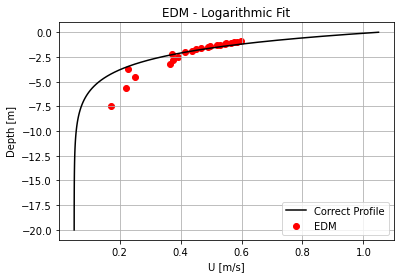

In [17]:
plt.plot(U, z, label = 'Correct Profile', color = 'black')
plt.scatter(Ux, -1/(3.56*wavenumbers), label='EDM', color = 'red')

plt.grid(True)
plt.title("EDM - Logarithmic Fit")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

# 2) PEDM Method

In [18]:
Z_eff = -1/(2*wavenumbers)
# Effective Depths using linear profile

In [19]:
Z_eff

array([-13.32922793,  -9.99691895,  -7.99753548,  -6.66461308,
        -5.7125256 ,  -4.99845997,  -4.44307558,  -3.99876806,
        -3.63524372,  -3.33230654,  -3.0759753 ,  -2.8562628 ,
        -2.6658453 ,  -2.49922999,  -2.35221647,  -2.22153779,
        -2.10461467,  -1.99938395,  -1.9041752 ,  -1.81762179,
        -1.73859477,  -1.66615332])

In [20]:
nMax_vals = None
deltaz_T_vals = None
deltaz_B_vals = None

In [21]:
if nMax_vals is None or not nMax_vals:
    nm = min(12, round(len(wavenumbers) / 2))
    nMax_vals = np.arange(nm + 1)
    
# Check and set deltaz_T_vals if it is None or empty
if deltaz_T_vals is None or len(deltaz_T_vals) == 0:
    depthRange = np.abs(Z_eff[0] - Z_eff[-1])
    deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

# Check and set deltaz_B_vals if it is None or empty
if deltaz_B_vals is None or len(deltaz_B_vals) == 0:
    depthRange = np.abs(Z_eff[0] - Z_eff[-1])
    deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

In [22]:
# polynomial order
nMax_vals

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [23]:
deltaz_T_vals
# Shallow end Depth interval for extrapolation

array([0.11663075, 0.23326149, 0.34989224, 0.46652298, 0.58315373,
       0.69978448, 0.81641522, 0.93304597, 1.04967671, 1.16630746,
       1.28293821, 1.39956895, 1.5161997 , 1.63283044, 1.74946119,
       1.86609194, 1.98272268, 2.09935343, 2.21598418, 2.33261492])

In [24]:
deltaz_B_vals
# Deep end Depth interval for extrapolation

array([0.23326149, 0.7120614 , 1.1908613 , 1.66966121, 2.14846111,
       2.62726102, 3.10606092, 3.58486083, 4.06366073, 4.54246064,
       5.02126054, 5.50006045, 5.97886035, 6.45766026, 6.93646016,
       7.41526007, 7.89405997, 8.37285988, 8.85165978, 9.33045969])

In [25]:
z_c = max(4 * np.min(Z_eff), -np.abs(np.inf))
z_c
# Cut off Depth

-53.316911724522186

## 2.1) Just do one value

In [26]:
nMax = nMax_vals[11]
# poly of order 3
deltaz_B = deltaz_B_vals[6]
deltaz_T =  deltaz_T_vals[7]

In [27]:
# Polynomial fitting using polyfit
p1 = np.polyfit(Z_eff, Ux, nMax)
p1

array([-3.53458207e-07, -2.12704883e-05, -5.62333365e-04, -8.64781230e-03,
       -8.61316239e-02, -5.83516901e-01, -2.73849556e+00, -8.86998717e+00,
       -1.93429165e+01, -2.69105997e+01, -2.12798712e+01, -6.55289156e+00])

In [28]:
# Linearly spaced depths for extrapolation
zB = np.linspace(0, deltaz_B, 100)
zT = np.linspace(-deltaz_T, 0, 100)

# Linear fit within depth interval deltaz_T from the top of the range of mapped depths
pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)

# Linear fit within depth interval deltaz_B from the bottom of the range of mapped depths
pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

# Depths below the deepest mapped depths
depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)

# Depth values above the shallowest mapped depth
depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

# Expanded range of depths, including the depths where the current is extrapolated
zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))

# Expanded range of current values, including extrapolated
cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), Ux, np.polyval(pTop, depthsExTop)))


In [29]:
# Perform a second polynomial fit on the expanded set of points to produce the profile considered U_EDM
pEDM = np.polyfit(zEx, cTilEx, nMax)

# Determine if the profile is monotonic with the range of mapped depths.
nv = np.arange(nMax, 0, -1)
pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
rts = np.roots(pczEx_p)  # Find roots
rts = rts[np.isreal(rts)]  # Discard complex roots

In [30]:
# Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article
n_factorial = np.array([np.math.factorial(i) for i in range(nMax, -1, -1)])
pPEDM_i = pEDM / n_factorial

In [31]:
# Linearly extrapolated points down to z_c based on the average shear
zB2 = np.linspace(0, deltaz_B/2, 100)

# Linear fit within depth interval deltaz_B/2 from the bottom of the range of mapped depths
pBottom2 = np.polyfit(Z_eff[0] + zB2, np.polyval(pPEDM_i, Z_eff[0] + zB2), 1)

# Depths below the deepest mapped depths
depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B/2)

# Expanded range of depths, including the depths where the current is extrapolated
zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))

# Expanded range of current values, including extrapolated
Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

In [32]:
# Perform a final polynomial fit on the expanded set of points
pPEDM = np.polyfit(zEx2, Uvals, nMax)

In [33]:
import numpy as np
from scipy.special import gamma, gammaincc

# Assuming nMax, k_vect, pEDM, and z_c are already defined
# If not, you need to define them appropriately before using this code

c_tilEDM = 0
c_tilPEDM = 0

if nMax < 2:
    for n in range(nMax + 1):
        # Use equation (5)
        c_tilEDM += np.math.factorial(n) * pEDM[-1 - n] * (-1 / (2 * wavenumbers)) ** n
        c_tilPEDM += np.math.factorial(n) * pEDM[-1 - n] * (-1 / (2 * wavenumbers)) ** n
else:
    for n in range(nMax + 1):
        # Use incomplete gamma function
        c_tilEDM += (-1 / 2) ** n * wavenumbers ** (-n) * pEDM[-1 - n] * (gammaincc(-2 * wavenumbers * z_c, 1 + n,) * gamma(n + 1))
        c_tilPEDM += (-1 / 2) ** n * wavenumbers ** (-n) * pEDM[-1 - n] * (gammaincc(-2 * wavenumbers * z_c, 1 + n) * gamma(n + 1))


In [34]:
eps_PEDM_out = np.inf
eps_EDM_out = np.inf

pPEDM_out = np.nan
pEDM_out = np.nan

In [35]:
import numpy as np

# Assuming c_til, c_tilEDM, c_tilPEDM, eps_PEDM_out, pPEDM_out, nMax_out, deltaz_B_out, deltaz_T_out, eps_EDM_out, pEDM_out are already defined
# If not, you need to define them appropriately before using this code

# Calculate RMS differences (equation (9) in manuscript)
eps_EDM = np.sqrt(np.mean((Ux - c_tilEDM)**2))  # RMS difference for U_EDM
eps_PEDM = np.sqrt(np.mean((Ux - c_tilPEDM)**2))  # RMS difference for U_PEDM

# Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
if eps_PEDM < eps_PEDM_out:
    eps_PEDM_out = eps_PEDM
    pPEDM_out = pPEDM
    nMax_out = nMax
    deltaz_B_out = deltaz_B
    deltaz_T_out = deltaz_T
    print(f"deltaz_B: {deltaz_B_out}, deltaz_T: {deltaz_T_out}, eps_PEDM_out: {eps_PEDM_out}, max(c_tilPEDM): {np.max(c_tilPEDM)}")

if eps_EDM < eps_EDM_out:
    eps_EDM_out = eps_EDM
    pEDM_out = pEDM


deltaz_B: 3.106060921468131, deltaz_T: 0.9330459685042607, eps_PEDM_out: 1047.043067982276, max(c_tilPEDM): 0.04113316941909864


In [36]:
pPEDM

array([-4.76029341e-14, -1.24039207e-11, -1.29409020e-09, -6.41494578e-08,
       -9.84970070e-07,  5.26627429e-05,  3.27118174e-03,  7.88760746e-02,
        9.34412301e-01,  4.17120443e+00,  3.29792262e+00, -5.67747359e-01])

In [37]:
pEDM

array([ 2.70673815e-12,  7.61014050e-10,  9.13485406e-08,  6.09437259e-06,
        2.46225145e-04,  6.14564880e-03,  9.24904538e-02,  7.82612286e-01,
        3.30747110e+00,  5.54523696e+00,  1.44463142e+00, -9.56943161e-01])

In [38]:
U1_fun = lambda z: np.polyval(pPEDM, z)

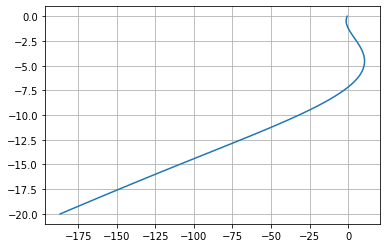

In [39]:
plt.plot(U1_fun(z),z)

plt.grid(True)

## 2.2) Loop

In [40]:
eps_PEDM_out = np.inf
eps_EDM_out = np.inf

pPEDM_out = np.nan
pEDM_out = np.nan

for nMax in nMax_vals:
    for deltaz_B in deltaz_B_vals:
        for deltaz_T in deltaz_T_vals:
            
            # Polynomial fitting using polyfit
            p1 = np.polyfit(Z_eff, Ux, nMax)
            
            # Linearly spaced depths for extrapolation
            zB = np.linspace(0, deltaz_B, 100)
            zT = np.linspace(-deltaz_T, 0, 100)

            # Linear fit within depth interval deltaz_T from the top of the range of mapped depths
            pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)

            # Linear fit within depth interval deltaz_B from the bottom of the range of mapped depths
            pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

            # Depths below the deepest mapped depths
            depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)

            # Depth values above the shallowest mapped depth
            depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

            # Expanded range of depths, including the depths where the current is extrapolated
            zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))

            # Expanded range of current values, including extrapolated
            cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), Ux, np.polyval(pTop, depthsExTop)))
            
            
            
            # Perform a second polynomial fit on the expanded set of points to produce the profile considered U_EDM
            pEDM = np.polyfit(zEx, cTilEx, nMax)

            # Determine if the profile is monotonic with the range of mapped depths.
            nv = np.arange(nMax, 0, -1)
            pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
            rts = np.roots(pczEx_p)  # Find roots
            rts = rts[np.isreal(rts)]  # Discard complex roots
            
            if any(np.logical_and(rts > Z_eff[0], rts < 0)):
                continue
            
            # Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article
            n_factorial = np.array([np.math.factorial(i) for i in range(nMax, -1, -1)])
            pPEDM_i = pEDM / n_factorial      
            
            ### Step 5 ###
            
            # Linearly extrapolated points down to z_c based on the average shear
            zB2 = np.linspace(0, deltaz_B/2, 100)

            # Linear fit within depth interval deltaz_B/2 from the bottom of the range of mapped depths
            pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

            # Depths below the deepest mapped depths
            depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B/2)

            # Expanded range of depths, including the depths where the current is extrapolated
            zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))

            # Expanded range of current values, including extrapolated
            Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))
            
            # Perform a final polynomial fit on the expanded set of points
            pPEDM = np.polyfit(zEx2, Uvals, nMax)
            
            c_tilEDM = sum(factorial(np.arange(nMax + 1)) * pPEDM[-(nMax + 1) :] * (-1 / (2 * wavenumbers)) ** np.arange(nMax + 1))
            c_tilPEDM = sum(factorial(np.arange(nMax + 1)) * pPEDM[-(nMax + 1) :] * (-1 / (2 * wavenumbers)) ** np.arange(nMax + 1))            
            
            
            
            
            
            
            
            
            #c_tilEDM = 0
            #c_tilPEDM = 0
            
            #if nMax < 2:
             #   for n in range(nMax + 1):
              #      # Use equation (5)
               #     c_tilEDM += np.math.factorial(n) * pEDM[-1 - n] * (-1 / (2 * wavenumbers)) ** n
                #    c_tilPEDM += np.math.factorial(n) * pPEDM[-1 - n] * (-1 / (2 * wavenumbers)) ** n
          #  else:
           #     for n in range(nMax + 1):
            #        # Use incomplete gamma function
             #       c_tilEDM += (-1 / 2) ** n * wavenumbers ** (-n) * pEDM[-1 - n] * (gammaincc(-2 * wavenumbers * z_c, 1 + n,) * gamma(n + 1))
              #      c_tilPEDM += (-1 / 2) ** n * wavenumbers ** (-n) * pPEDM[-1 - n] * (gammaincc(-2 * wavenumbers * z_c, 1 + n) * gamma(n + 1))

                    
            # Calculate RMS differences (equation (9) in manuscript)
            eps_EDM = np.sqrt(np.mean((Ux - c_tilEDM)**2))  # RMS difference for U_EDM
            eps_PEDM = np.sqrt(np.mean((Ux - c_tilPEDM)**2))  # RMS difference for U_PEDM

            # Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
            if eps_PEDM < eps_PEDM_out:
                eps_PEDM_out = eps_PEDM
                pPEDM_out = pPEDM
                nMax_out = nMax
                deltaz_B_out = deltaz_B
                deltaz_T_out = deltaz_T
                #print(f"deltaz_B: {deltaz_B_out}, deltaz_T: {deltaz_T_out}, eps_PEDM_out: {eps_PEDM_out}, max(c_tilPEDM): {np.max(c_tilPEDM)}")

            if eps_EDM < eps_EDM_out:
                eps_EDM_out = eps_EDM
                pEDM_out = pEDM

NameError: name 'factorial' is not defined

In [41]:
eps_PEDM

1047.043067982276

In [42]:
pPEDM

array([0.43588063])

In [43]:
U1_fun = lambda z: np.polyval(pPEDM, z)

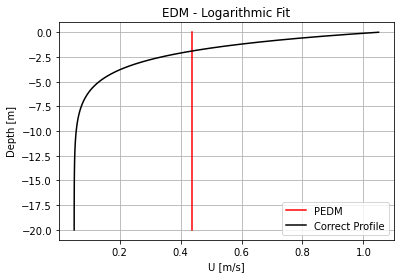

In [44]:
plt.plot(U1_fun(z), z, label="PEDM", color = 'red')

plt.plot(U, z, label = 'Correct Profile', color = 'black')
#plt.scatter(Ux, -1/(2*wavenumbers), label='EDM', color = 'red')

plt.grid(True)
plt.title("EDM - Logarithmic Fit")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()
#plt.xlim(-1,1)

In [45]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [46]:
import numpy as np
import scipy as sp
from scipy.optimize import fsolve
from scipy.special import gamma, gammainc
from numpy.polynomial import Polynomial
from numpy import roots, linspace, polyfit, polyval, sqrt

# Define your constants and arrays here

eps_PEDM_out = float('inf') 
combo = 0
verbose = []

for nMax in nMax_vals:
    for deltaz_B in deltaz_B_vals:
        for deltaz_T in deltaz_T_vals:

            # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
            p1 = polyfit(Z_eff, Ux, nMax)

            # STEP 2: Create additional velocity-depth pairs by linearly extrapolating
            # up to the surface and down to cutoff depth z_c
            zB = linspace(0, deltaz_B, 100)
            zT = linspace(-deltaz_T, 0, 100)

            pTop = polyfit(Z_eff[-1] + zT, polyval(p1, Z_eff[-1] + zT), 1)
            pBottom = polyfit(Z_eff[0] + zB, polyval(p1, Z_eff[0] + zB), 1)

            depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
            depthsExTop = np.concatenate(
                [np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]]
            )

            zEx = np.concatenate([depthsExBtm, Z_eff, depthsExTop])
            cTilEx = np.concatenate(
                [polyval(pBottom, depthsExBtm), Ux, polyval(pTop, depthsExTop)]
            )

            # STEP 3: Perform a second polynomial fit on the expanded set of points
            # to produce the profile considered U_EDM.
            pEDM = polyfit(zEx, cTilEx, nMax)

            nv = np.arange(nMax, 0, -1)
            pczEx_p = nv * pEDM[:-1]
            rts = roots(pczEx_p)
            rts = rts[np.isreal(rts)]

            if any(np.logical_and(rts > Z_eff[0], rts < 0)):
                continue

            # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8)
            pPEDM_i = pEDM / sp.special.factorial(np.arange(nMax, -1, -1))

            # STEP 5: Create a new set of linearly extrapolated points down to z_c
            zB2 = linspace(0, deltaz_B / 2, 100)
            pBottom2 = polyfit(Z_eff[0] + zB, polyval(pPEDM_i, Z_eff[0] + zB), 1)

            depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B / 2)

            zEx2 = np.concatenate([depthsExBtm2, Z_eff, depthsExTop])
            Uvals = np.concatenate([polyval(pBottom2, depthsExBtm2), polyval(pPEDM_i, Z_eff), polyval(pPEDM_i, depthsExTop)])

            # STEP 6: Perform a final polynomial fit on the expanded set of points.
            pPEDM = polyfit(zEx2, Uvals, nMax)

            
            
            # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile
            c_tilEDM = sum(
                sp.special.factorial(np.arange(nMax + 1)) * pEDM[-(nMax + 1) :] * (-1 / (2 * wavenumbers)) ** np.arange(nMax + 1)
            )
            
            c_tilPEDM = sum(
                sp.special.factorial(np.arange(nMax + 1)) * pPEDM[-(nMax + 1) :] * (-1 / (2 * wavenumbers)) ** np.arange(nMax + 1)
            )

            if nMax >= 2:
                c_tilEDM = sum(
                    ((-1 / 2) ** np.arange(nMax + 1)) * (wavenumbers ** -np.arange(nMax + 1)) * pEDM[-(nMax+1 ) :]
                    * gammainc(-2 * wavenumbers * z_c, 1 + np.arange(nMax + 1))
                    / gamma(np.arange(nMax + 1) + 1)
                )
                c_tilPEDM = sum(
                    ((-1 / 2) ** np.arange(nMax + 1)) * (wavenumbers ** -np.arange(nMax + 1)) * pPEDM[-(nMax + 1) :]
                    * gammainc(-2 * wavenumbers * z_c, 1 + np.arange(nMax + 1))
                    / gamma(np.arange(nMax + 1) + 1)
                )

            eps_EDM = rms(Ux - c_tilEDM)
            eps_PEDM = rms(Ux - c_tilPEDM)

            if eps_PEDM <  eps_PEDM_out:
                eps_PEDM_out = eps_PEDM
                pPEDM_out = pPEDM
                nMax_out = nMax
                deltaz_B_out = deltaz_B
                deltaz_T_out = deltaz_T

            if eps_EDM < eps_EDM_out:
                eps_EDM_out = eps_EDM
                pEDM_out = pEDM

            verbose.append({
                'pPEDM': pPEDM,
                'pEDM': pEDM,
                'eps_PEDM': eps_PEDM,
                'eps_EDM': eps_EDM,
                'nMax': nMax,
                'deltaz_B': deltaz_B,
                'deltaz_T': deltaz_T
            })
            combo += 1


ValueError: operands could not be broadcast together with shapes (22,) (2,) 

In [ ]:
verbose

In [47]:
pPEDM.shape

(2,)

In [48]:
c_tilPEDM = sum(
                    ((-1 / 2) ** np.arange(nMax + 1)) * (wavenumbers ** -np.arange(nMax + 1)) * pPEDM[-(nMax + 1) :]
                    * gammainc(-2 * wavenumbers * z_c, 1 + np.arange(nMax + 1))
                    / gamma(np.arange(nMax + 1) + 1)
                )

ValueError: operands could not be broadcast together with shapes (22,) (2,) 

In [49]:
c_tilPEDM

9.589373910000004

In [50]:
eps_PEDM = rms(Ux - c_tilPEDM)

In [51]:
eps_PEDM

9.154343875618421

In [52]:
type(np.inf)

float

In [53]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [54]:
np.math.factorial

<function math.factorial(x, /)>

In [55]:
import scipy as sp

In [56]:
sp.special.factorial(3)

6.0

In [57]:
array = np.array([1,2,3,4,5, np.inf])

In [58]:
if np.all(array < np.inf):
    print('8')

In [59]:
import numpy as np
from scipy.optimize import fsolve
from scipy.special import gamma, gammainc
from numpy.polynomial import Polynomial
from numpy import roots, linspace, polyfit, polyval, sqrt

# Define your constants and arrays here

eps_PEDM_out = float('inf') 
combo = 0
verbose = []

for nMax in nMax_vals:
    for deltaz_B in deltaz_B_vals:
        for deltaz_T in deltaz_T_vals:

            # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
            p1 = polyfit(Z_eff, Ux, nMax)

            # STEP 2: Create additional velocity-depth pairs by linearly extrapolating
            # up to the surface and down to cutoff depth z_c
            zB = linspace(0, deltaz_B, 100)
            zT = linspace(-deltaz_T, 0, 100)

            pTop = polyfit(Z_eff[-1] + zT, polyval(p1, Z_eff[-1] + zT), 1)
            pBottom = polyfit(Z_eff[0] + zB, polyval(p1, Z_eff[0] + zB), 1)

            depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
            depthsExTop = np.concatenate(
                [np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]]
            )

            zEx = np.concatenate([depthsExBtm, Z_eff, depthsExTop])
            cTilEx = np.concatenate(
                [polyval(pBottom, depthsExBtm), Ux, polyval(pTop, depthsExTop)]
            )

            # STEP 3: Perform a second polynomial fit on the expanded set of points
            # to produce the profile considered U_EDM.
            pEDM = polyfit(zEx, cTilEx, nMax)

            nv = np.arange(nMax, 0, -1)
            pczEx_p = nv * pEDM[:-1]
            rts = roots(pczEx_p)
            rts = rts[np.isreal(rts)]

            if any(np.logical_and(rts > Z_eff[0], rts < 0)):
                continue

            # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8)
            pPEDM_i = pEDM / sp.special.factorial(np.arange(nMax, -1, -1))

            # STEP 5: Create a new set of linearly extrapolated points down to z_c
            zB2 = linspace(0, deltaz_B / 2, 100)
            pBottom2 = polyfit(Z_eff[0] + zB, polyval(pPEDM_i, Z_eff[0] + zB), 1)

            depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B / 2)

            zEx2 = np.concatenate([depthsExBtm2, Z_eff, depthsExTop])
            Uvals = np.concatenate([polyval(pBottom2, depthsExBtm2), polyval(pPEDM_i, Z_eff), polyval(pPEDM_i, depthsExTop)])

            # STEP 6: Perform a final polynomial fit on the expanded set of points.
            pPEDM = polyfit(zEx2, Uvals, nMax)
            
            # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile
            c_tilEDM = sum(
                sp.special.factorial(np.arange(nMax + 1)) * pEDM[-(nMax + 1) :] * (-1 / (2 * wavenumbers)) ** np.arange(nMax + 1)
            )
            
            c_tilPEDM = sum(
                sp.special.factorial(np.arange(nMax + 1)) * pPEDM[-(nMax + 1) :] * (-1 / (2 * wavenumbers)) ** np.arange(nMax + 1)
            )

            if nMax >= 2:
                c_tilEDM = sum(
                    ((-1 / 2) ** np.arange(nMax + 1)) * (wavenumbers ** -np.arange(nMax + 1)) * pEDM[-(nMax+1 ) :]
                    * gammainc(-2 * wavenumbers * z_c, 1 + np.arange(nMax + 1))
                    / gamma(np.arange(nMax + 1) + 1)
                )
                c_tilPEDM = sum(
                    ((-1 / 2) ** np.arange(nMax + 1)) * (wavenumbers ** -np.arange(nMax + 1)) * pPEDM[-(nMax + 1) :]
                    * gammainc(-2 * wavenumbers * z_c, 1 + np.arange(nMax + 1))
                    / gamma(np.arange(nMax + 1) + 1)
                )

            eps_EDM = rms(Ux - c_tilEDM)
            eps_PEDM = rms(Ux - c_tilPEDM)

            if eps_PEDM <  eps_PEDM_out:
                eps_PEDM_out = eps_PEDM
                pPEDM_out = pPEDM
                nMax_out = nMax
                deltaz_B_out = deltaz_B
                deltaz_T_out = deltaz_T

            if eps_EDM < eps_EDM_out:
                eps_EDM_out = eps_EDM
                pEDM_out = pEDM

            combo += 1
    verbose.append({
                'pPEDM': pPEDM,
                'pEDM': pEDM,
                'eps_PEDM': eps_PEDM,
                'eps_EDM': eps_EDM,
                'nMax': nMax,
                'deltaz_B': deltaz_B,
                'deltaz_T': deltaz_T
            })

ValueError: operands could not be broadcast together with shapes (22,) (2,) 

In [60]:
nMax_vals[:-2]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [61]:
thing = []

for nMax in nMax_vals[:-2]:
    for deltaz_B in deltaz_B_vals:
        for deltaz_T in deltaz_T_vals:

            # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
            p1 = polyfit(Z_eff, Ux, nMax)

            # STEP 2: Create additional velocity-depth pairs by linearly extrapolating
            # up to the surface and down to cutoff depth z_c
            zB = linspace(0, deltaz_B, 100)
            zT = linspace(-deltaz_T, 0, 100)

            pTop = polyfit(Z_eff[-1] + zT, polyval(p1, Z_eff[-1] + zT), 1)
            pBottom = polyfit(Z_eff[0] + zB, polyval(p1, Z_eff[0] + zB), 1)

            depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
            depthsExTop = np.concatenate(
                [np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]]
            )

            zEx = np.concatenate([depthsExBtm, Z_eff, depthsExTop])
            cTilEx = np.concatenate(
                [polyval(pBottom, depthsExBtm), Ux, polyval(pTop, depthsExTop)]
            )

            # STEP 3: Perform a second polynomial fit on the expanded set of points
            # to produce the profile considered U_EDM.
            pEDM = polyfit(zEx, cTilEx, nMax)
            
    thing.append(pEDM)

In [62]:
thing

[array([0.43588063]),
 array([0.03952221, 0.59937733]),
 array([2.13584858e-04, 3.69894941e-02, 5.91542032e-01]),
 array([1.59304783e-05, 1.46423651e-03, 5.84934882e-02, 6.47100082e-01]),
 array([8.43553490e-07, 1.00497210e-04, 3.96860061e-03, 8.14419418e-02,
        6.90632205e-01]),
 array([3.89727965e-08, 5.96140886e-06, 3.37530365e-04, 8.62971390e-03,
        1.11102652e-01, 7.33959306e-01]),
 array([3.18225146e-10, 8.53671740e-08, 8.43572675e-06, 3.97017946e-04,
        9.29217106e-03, 1.13970887e-01, 7.37353915e-01]),
 array([-1.63065305e-09, -2.64926032e-07, -1.61142357e-05, -4.47455029e-04,
        -5.42207989e-03, -2.24831090e-02,  5.27214171e-02,  7.14321324e-01]),
 array([7.15534609e-10, 1.18259416e-07, 7.43537715e-06, 2.22005343e-04,
        3.24614304e-03, 2.32690982e-02, 8.15679182e-02, 1.95796977e-01,
        7.49130839e-01]),
 array([-1.54610440e-10, -2.65398035e-08, -1.77460384e-06, -5.89195836e-05,
        -1.04089736e-03, -1.00732934e-02, -5.24507928e-02, -1.29132004

In [63]:
nMax_vals.shape

(12,)

In [64]:
pEDM.shape

(10,)

In [65]:
c_tilEDM = sum(sp.special.factorial(np.arange(nMax + 1)) * pEDM[-(nMax + 1) :] * (-1 / (2 * wavenumbers)) ** np.arange(nMax + 1))

ValueError: operands could not be broadcast together with shapes (22,) (10,) 

# function

In [210]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.special import factorial, gammaincc, gamma
from numpy.polynomial import Polynomial

def rms(x):
    return np.sqrt(np.mean(x**2))

def pedm(k_vect, c_til, nMax_vals=None, deltaz_T_vals=None, deltaz_B_vals=None, waterDepth=None):
    # Define Root-mean-square function for later use
    rms = lambda x: np.sqrt(np.mean(x**2))

    # If user has not provided information about the waterDepth, set to infinity
    if waterDepth is None:
        waterDepth = np.inf

    # Handling for inadequate input data.
    if len(k_vect) == 0 or len(c_til) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    # Now we start with the PEDM. The steps follow those in the manuscript in section 2.1.2 Effect of limitations of measured Doppler shifts
    # Define the parameters.
    # Calculate effective depths of Doppler shift velocities based on assumption of a linear profile
    Z_eff = -(2 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

    # Set default values for PEDM parameter combinations if inputs left blank
    if nMax_vals is None:
        nm = min(12, round(len(k_vect) / 2))
        nMax_vals = np.arange(0, nm+1)
    
    if deltaz_T_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

    if deltaz_B_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

    z_c = max(4 * np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth. (Set to water depth if depth is shallower)
    # z_c is NEGATIVE by convention here

    # We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
    eps_PEDM_out = np.inf
    eps_EDM_out = np.inf

    pPEDM_out = np.nan
    pEDM_out = np.nan

    verbose = []
    combo = 0

    for nMax in nMax_vals:
        for deltaz_B in deltaz_B_vals:
            for deltaz_T in deltaz_T_vals:
                # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
                p1 = np.polyfit(Z_eff, c_til, nMax)

                # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
                zB = np.linspace(0, deltaz_B, 100)
                zT = np.linspace(-deltaz_T, 0, 100)

                pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
                pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

                depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
                depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

                zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
                cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

                # STEP 3: Perform a second polynomial fit on the expanded set of points
                pEDM = np.polyfit(zEx, cTilEx, nMax)

                # Determine if profile is monotonic with range of mapped depths.
                nv = np.arange(nMax, 0, -1)
                pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
                rts = np.roots(pczEx_p)  # Find roots
                rts = rts[np.isreal(rts)]  # Discard complex roots

                # If there roots of the derivative within ranges of mapped depths, don't go further.
                if np.any((rts > Z_eff[0]) & (rts < 0)):
                    continue

                # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
                pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

                # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
                zB2 = np.linspace(0, deltaz_B/2, 100)
                pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

                depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B/2)

                zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
                Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

                # STEP 6: Perform a final polynomial fit on the expanded set of points.
                pPEDM = np.polyfit(zEx2, Uvals, nMax)

                # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile, using the forward problem.
                c_tilEDM = 0
                c_tilPEDM = 0

                if nMax < 2:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + factorial(n) * pEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                        c_tilPEDM = c_tilPEDM + factorial(n) * pPEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                else:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pEDM[-n-1] * (gammaincc(-2 * k_vect * z_c, 1 + n)) * gamma(n + 1)
                        c_tilPEDM = c_tilPEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pPEDM[-n-1] * (gammaincc(-2 * k_vect * z_c, 1 + n)) * gamma(n + 1)

                # Calculate RMS differences (equation (9) in manuscript)
                eps_EDM = rms(c_til - c_tilEDM)  # RMS difference for U_EDM
                eps_PEDM = rms(c_til - c_tilPEDM)  # RMS difference for U_PEDM.

                # Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
                if eps_PEDM < eps_PEDM_out:
                    eps_PEDM_out = eps_PEDM
                    pPEDM_out = pPEDM
                    nMax_out = nMax
                    deltaz_B_out = deltaz_B
                    deltaz_T_out = deltaz_T

                if eps_EDM < eps_EDM_out:
                    eps_EDM_out = eps_EDM
                    pEDM_out = pEDM

                combo = combo + 1
                verbose.append({
                    #'pPEDM': pPEDM.tolist(),
                    #'pEDM': pEDM.tolist(),
                    'pPEDM': pPEDM,
                    'pEDM': pEDM,
                    'eps_PEDM': eps_PEDM,
                    'eps_EDM': eps_EDM,
                    'nMax': nMax,
                    'deltaz_B': deltaz_B,
                    'deltaz_T': deltaz_T
                })

                
                #return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose
    return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose

# Example usage:
pPEDM, pEDM, eps_PEDM, eps_EDM, verbose = pedm(wavenumbers, Ux)


In [220]:
from scipy.special import factorial, gammaincc, gamma
gammaincc([1, 2, 3, 4], 5)

array([0.00673795, 0.04042768, 0.12465202, 0.26502592])

In [211]:
verbose[0]

{'pPEDM': array([0.43588063]),
 'pEDM': array([0.43588063]),
 'eps_PEDM': 0.12479025472386776,
 'eps_EDM': 0.12479025472386776,
 'nMax': 0,
 'deltaz_B': 0.23326149212606517,
 'deltaz_T': 0.11663074606303259}

## find min and plot

In [212]:
# Find the PEDM polynomials when eps_PEDM is minimum

min_eps_PEDM_dict = min(verbose, key=lambda x: np.min(x['eps_PEDM']))
print(min_eps_PEDM_dict)

{'pPEDM': array([8.34038287e-10, 1.80845858e-07, 1.57804817e-05, 7.05457662e-04,
       1.69314313e-02, 1.99094740e-01, 8.49339514e-01]), 'pEDM': array([4.30197853e-09, 7.58405002e-07, 5.12774668e-05, 1.63760969e-03,
       2.37774054e-02, 1.80551487e-01, 8.33738268e-01]), 'eps_PEDM': 0.019307163868434722, 'eps_EDM': 0.0659736046180556, 'nMax': 6, 'deltaz_B': 1.1908613019067538, 'deltaz_T': 0.46652298425213035}


In [213]:
U1_fun = lambda z: np.polyval(min_eps_PEDM_dict['pPEDM'], z)

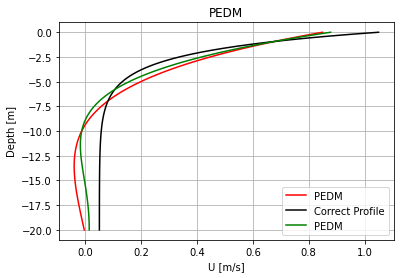

In [215]:
plt.plot(U1_fun(z), z, label="PEDM", color = 'red')

plt.plot(U, z, label = 'Correct Profile', color = 'black')
#plt.scatter(Ux, -1/(2*wavenumbers), label='EDM', color = 'red')

plt.plot(U_tester_fun(z), z, label="PEDM", color = 'green')

plt.grid(True)
plt.title("PEDM")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

In [137]:
verbose[2715]

{'pPEDM': array([-1.59513111e-10, -3.08496790e-08, -2.35274094e-06, -8.89817738e-05,
        -1.69865648e-03, -1.38961662e-02,  5.32919874e-02,  7.20617492e-01]),
 'pEDM': array([-1.63065305e-09, -2.64926032e-07, -1.61142357e-05, -4.47455029e-04,
        -5.42207989e-03, -2.24831090e-02,  5.27214171e-02,  7.14321324e-01]),
 'eps_PEDM': 1.3807542636278238,
 'eps_EDM': 18.813223914573417,
 'nMax': 7,
 'deltaz_B': 9.330459685042607,
 'deltaz_T': 2.3326149212606517}

In [150]:
correct_last_row_ppedm = np.array([-1.141062713814869e-10,-1.963712343337823e-08,-1.249375680747990e-06,-3.395215499295023e-05,-2.474376957221186e-04,0.004920001237364,0.138404216839451,0.787658618112140])

In [155]:
tester = np.array([-3.16299173241975e-11, -3.52342289978936e-09, 2.26061970004925e-08, 1.87040323555655e-05, 0.00100884400351229, 0.0229985582258079, 0.236443508029221, 0.878525552099846])

In [ ]:
[-3.168178094429970e-11,-4.034839333262326e-09,-7.301516604787736e-08,1.159622225203049e-05,7.447130642857188e-04,0.017909147126642,0.200120319672119,0.834158999358281]

In [69]:
nMax_vals

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [70]:
deltaz_T_vals.shape

(20,)

In [71]:
count_nMax_zero = sum(1 for entry in verbose if entry['nMax'] == 6)
count_nMax_zero

256

In [143]:
len(verbose)

2716

In [98]:
verbose[2714]['pPEDM']

array([-1.59567515e-10, -3.07730684e-08, -2.33684587e-06, -8.77460836e-05,
       -1.65113452e-03, -1.29479316e-02,  5.99687701e-02,  7.28784632e-01])

In [151]:
correct_last_row_ppedm

array([-1.14106271e-10, -1.96371234e-08, -1.24937568e-06, -3.39521550e-05,
       -2.47437696e-04,  4.92000124e-03,  1.38404217e-01,  7.87658618e-01])

In [144]:
U1_fun = lambda z: np.polyval(verbose[2714]['pPEDM'], z)

In [152]:
U1_fun = lambda z: np.polyval(correct_last_row_ppedm, z)

In [156]:
U_tester_fun = lambda z: np.polyval(tester, z)

In [153]:
U1_fun(z).shape

(100,)

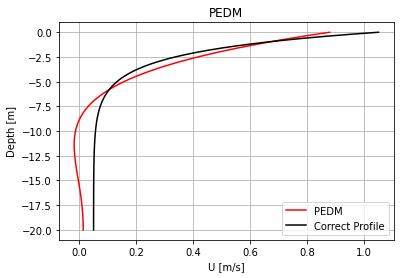

In [157]:
#plt.plot(U1_fun(z), z, label="PEDM", color = 'red')
plt.plot(U_tester_fun(z), z, label="PEDM", color = 'red')

plt.plot(U, z, label = 'Correct Profile', color = 'black')
#plt.scatter(Ux, -1/(2*wavenumbers), label='EDM', color = 'red')

plt.grid(True)
plt.title("PEDM")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()
#plt.xlim(-1,1)

In [77]:
factorial(np.arange(11, -1, -1))

array([3.99168e+07, 3.62880e+06, 3.62880e+05, 4.03200e+04, 5.04000e+03,
       7.20000e+02, 1.20000e+02, 2.40000e+01, 6.00000e+00, 2.00000e+00,
       1.00000e+00, 1.00000e+00])

In [113]:
from scipy.io import loadmat

# Load MATLAB variables from the .mat file
#mat_data = loadmat('C:\Users\josep\Documents\MATLAB\11_New_matlab_variables.mat')
mat_data1 = loadmat(r'C:\Users\josep\Documents\MATLAB\tester_to_checky.mat')

#"C:\Users\josep\Documents\MATLAB\11_New_matlab_variables.mat"
# Access the variables in Python
#pedm_vals_used = mat_data1['new_z_values']
#new_Ux_values = mat_data1['new_Ux_values']

# Now you can use new_z_values and new_Ux_values in Python

## Correct from Matlab code

In [115]:
mat_data1['pPEDM_1'][0].shape

(5,)

In [116]:
U2_fun = lambda z: np.polyval(mat_data1['pPEDM_1'][0], z)

In [117]:
U2_fun(z)

array([-0.55478742, -0.54382622, -0.53288301, -0.52195764, -0.51104988,
       -0.50015944, -0.48928595, -0.47842899, -0.46758804, -0.45676255,
       -0.44595185, -0.43515525, -0.42437197, -0.41360114, -0.40284185,
       -0.39209312, -0.38135387, -0.37062299, -0.35989927, -0.34918144,
       -0.33846816, -0.32775803, -0.31704957, -0.30634123, -0.2956314 ,
       -0.28491839, -0.27420043, -0.26347572, -0.25274234, -0.24199834,
       -0.23124168, -0.22047026, -0.2096819 , -0.19887436, -0.18804533,
       -0.17719242, -0.16631318, -0.15540509, -0.14446556, -0.13349192,
       -0.12248145, -0.11143134, -0.10033873, -0.08920067, -0.07801415,
       -0.0667761 , -0.05548336, -0.04413273, -0.0327209 , -0.02124453,
       -0.00970018,  0.00191564,  0.0136065 ,  0.02537603,  0.03722794,
        0.04916601,  0.06119408,  0.07331607,  0.08553595,  0.09785779,
        0.11028571,  0.12282389,  0.13547662,  0.1482482 ,  0.16114306,
        0.17416565,  0.18732053,  0.2006123 ,  0.21404564,  0.22

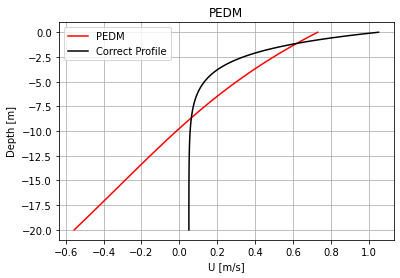

In [118]:
plt.plot(U2_fun(z), z, label="PEDM", color = 'red')

plt.plot(U, z, label = 'Correct Profile', color = 'black')
#plt.scatter(Ux, -1/(2*wavenumbers), label='EDM', color = 'red')

plt.grid(True)
plt.title("PEDM")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()
#plt.xlim(-1,1)

In [142]:
verbose[2714]['pPEDM']

array([-1.59567515e-10, -3.07730684e-08, -2.33684587e-06, -8.77460836e-05,
       -1.65113452e-03, -1.29479316e-02,  5.99687701e-02,  7.28784632e-01])

In [148]:
mat_data1['verby1']['pPEDM'][0][-2][0]

array([-1.14429327e-10, -1.95748986e-08, -1.23125474e-06, -3.24970038e-05,
       -1.93794268e-04,  5.88756676e-03,  1.44655845e-01,  7.94810949e-01])

In [149]:
U1_fun = lambda z: np.polyval(mat_data1['verby1']['pPEDM'][0][-2][0], z)

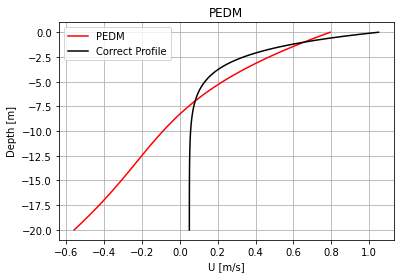

In [150]:
plt.plot(U1_fun(z), z, label="PEDM", color = 'red')

plt.plot(U, z, label = 'Correct Profile', color = 'black')
#plt.scatter(Ux, -1/(2*wavenumbers), label='EDM', color = 'red')

plt.grid(True)
plt.title("PEDM")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()
#plt.xlim(-1,1)